# Fine-tuning a Pretrained Network 

### Style Recognition

Take a pre-trained Caffe network and fine-tune the parameters on custom data.

The advantage of this approach is that, since pre-trained networks are learned on a large set of images, the intermediate layers capture the "semantics" of the general visual appearance. Only a relatively small amount of data is needed for good performance on the target task.

**Data Preparation**
1. Get the ImageNet ilsvrc pretrained `CaffeNet` model with the provided shell scripts.
2. Download a subset of the overall Flickr style dataset.
3. Compile the downloaded Flickr dataset into a database that Caffe can then consume.

In [1]:
caffe_root = '../'  # This Notebook should be run from {caffe_root}/examples 

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

caffe.set_device(0)
caffe.set_mode_gpu()

import numpy as np
from pylab import *
%matplotlib inline
import tempfile

# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # modify copy of data
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

** 1. Setup and dataset download**
- `get_ilsvrc_aux.sh` to download the ImageNet data mean, labels, etc.
- `download_model_binary.py` to download the pretrained reference model
- `finetune_flickr_style/assemble_data.py` downloads the style training and testing data

In [2]:
# Download just a small subset of the data: 2000 of 80K images, 5 of 20 labels.
full_dataset = False # To download the entire dataset, set `full_dataset = True`.
if full_dataset:
    NUM_STYLE_IMAGES = NUM_STYLE_LABELS = -1
else:
    NUM_STYLE_IMAGES = 2000
    NUM_STYLE_LABELS = 5

# This downloads the ilsvrc auxiliary data (mean file, etc), and a subset of 2k images for the style recognition.
import os
os.chdir(caffe_root)  # Run scripts from caffe root
!data/ilsvrc12/get_ilsvrc_aux.sh
!scripts/download_model_binary.py models/bvlc_reference_caffenet
!python examples/finetune_flickr_style/assemble_data.py \
    --workers=-1  --seed=1701 \
    --images=$NUM_STYLE_IMAGES  --label=$NUM_STYLE_LABELS
# Change directory to `examples`
os.chdir('examples')

Downloading...
--2017-03-15 14:56:58--  http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
Resolving dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17858008 (17M) [application/octet-stream]
Saving to: ‘caffe_ilsvrc12.tar.gz’

100%[======================================>] 17,858,008  1.41MB/s   in 12s    

2017-03-15 14:57:10 (1.47 MB/s) - ‘caffe_ilsvrc12.tar.gz’ saved [17858008/17858008]

Unzipping...
Done.
Model already exists.
Writing train/val for 1998 successfully downloaded images.


**Define path to the CaffeNet pretrained weights**

In [3]:
weights = os.path.join(caffe_root, 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')

# Check pretrained `weights` exists
assert os.path.exists(weights)

**Load the 1000 ImageNet labels from `ilsvrc12/synset_words.txt`, and the 5 style labels from `finetune_flickr_style/style_names.txt`.**

In [4]:
# Load ImageNet labels to imagenet_labels
imagenet_label_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
assert len(imagenet_labels) == 1000
print 'Loaded ImageNet labels:\n', '\n'.join(imagenet_labels[:5] + ['...'])

# Load style labels to style_labels
style_label_file = caffe_root + 'examples/finetune_flickr_style/style_names.txt'
style_labels = list(np.loadtxt(style_label_file, str, delimiter='\n'))
if NUM_STYLE_LABELS > 0:
    style_labels = style_labels[:NUM_STYLE_LABELS]
print '\nLoaded style labels:\n', ', '.join(style_labels)

Loaded ImageNet labels:
n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
n01494475 hammerhead, hammerhead shark
...

Loaded style labels:
Detailed, Pastel, Melancholy, Noir, HDR


**2. Defining and running the nets**

We'll start by defining `caffenet`, a function which initializes the *CaffeNet* architecture (a minor variant on *AlexNet*), taking arguments specifying the data and number of output classes.

In [5]:
from caffe import layers as L
from caffe import params as P

# lr_mult or decay_mult: what to multiply the learning rate by for a particular layer
# Train.prototxt: first param { } is for the weights and the second param { } is for the biases
weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1, param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    """
    Defines CONV-ReLU layer.
    
    Args:
        bottom: Layer input data
        ks (int): Kernel size
        nout (int): Number of kernels (output)
        stride (int): Stride length
        pad (int): Padding
        group (int): Implement grouped convolutions (https://github.com/BVLC/caffe/issues/778) 
        param (list): List of Weight and Bias parameters
        weight_filler (dict): Randomly initialized weights
        bias_filler (dict): Randomly initialized biases
        
    Returns:
        CONV-ReLU Layer output
    """
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    """
    Defines Fully Connected-ReLU layer.
    
    Args:
        bottom: Layer input data
        nout (int): Number of outputs
        param (list): List of Weight and Bias parameters
        weight_filler (dict): Randomly initialized weights
        bias_filler (dict): Randomly initialized biases
        
    Returns:
        Fully Connected-ReLU layer
    """
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    """
    Define Pooling Layer.
    
    Args:
        bottom: Layer input data
        ks (int): Kernel size
        stride (int): Stride length
        
    Returns:
        Down-sampled input
    """
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data, label=None, train=True, num_classes=1000, classifier_name='fc8', learn_all=False):
    """
    Returns a NetSpec specifying CaffeNet (variant of AlexNet). 
    
    CaffeNet proto text specification (./models/bvlc_reference_caffenet/train_val.prototxt).
    
    Args:
        data: Input data to network 
        label: Input data labels
        train (bool): Training phase (True) or Deployment phase (False).
        num_classes (int): Number of classes.
        classifier_name (str): Name to assign classifier.
        learn_all (bool): True (Learn all parameters) or False (Freeze all parameters in pretrained 
                          layers `conv1` through `fc7` and learn only the classifier layer `fc8_flickr`.
    """
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    
    # [Convolution-ReLU] 1
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    # [Max Pool] 1
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    # [Local Response Normalization] 1 : https://arxiv.org/pdf/1409.0575.pdf
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    
    # [Convolution-ReLU] 2
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    # [Max Pool] 2
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    # [Local Response Normalization] 2
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    
    # [Convolution-ReLU] 3
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    # [Convolution-ReLU] 4
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    # [Convolution-ReLU] 5
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    # [Max Pool] 3
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    
    # [Fully Connected-ReLU] 6
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    
    # Check training or deploying
    if train: 
        # [Dropout] 
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
        
    # [Fully Connected-ReLU] 7
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
    
    # Check training or deploying
    if train:
        # [Dropout]
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    
    # Softmax Loss: always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param) # No weight_filler or bias_filler
    
    # Give `fc8` the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
        
    # Write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        print f.name
        return f.name

Create a **CaffeNet** that takes unlabeled "dummy data" as input. This allows us to set its input images externally and see what ImageNet classes it predicts.

In [6]:
# Dummy data dimension: 1 image x 3 channels x 227 pixels wide x 227 pixels high
dummy_data = L.DummyData(shape=dict(dim=[1, 3, 227, 227]))
imagenet_net_filename = caffenet(data=dummy_data, train=False)

# net = caffe.Net('net_with_data_layer.prototxt', 'weights.caffemodel')
imagenet_net = caffe.Net(imagenet_net_filename, weights, caffe.TEST)

/tmp/tmpxsqPYh


#### Define a function `style_net` which calls `caffenet` on data from the Flickr style dataset.

The new network will also have the *CaffeNet* architecture, with differences in the input and output:

- The input is the Flickr Style data, provided by an `ImageData` layer
- The output is a distribution over 20 classes rather than the original 1000 ImageNet classes
- The classification layer is renamed from `fc8` to `fc8_flickr` to tell Caffe not to load the original classifier (`fc8`) weights from the ImageNet-pretrained model

In [7]:
def style_net(train=True, learn_all=False, subset=None):
    """
    Defines a custom net which calls `caffenet` function on data.
    """
    # Data path
    if subset is None:
        subset = 'train' if train else 'test'
    source = caffe_root + 'data/flickr_style/%s.txt' % subset
    
    # Data preprocessing: cropping and subtracting mean
    transform_param = dict(mirror=train, crop_size=227, 
                           mean_file=caffe_root + 'data/ilsvrc12/imagenet_mean.binaryproto')
    
    # NOTE: Modified height and width of image input as per new dataset
    style_data, style_label = L.ImageData(transform_param=transform_param, source=source,
                                          batch_size=50, new_height=256, new_width=256, ntop=2)
    
    return caffenet(data=style_data, label=style_label, train=train, num_classes=NUM_STYLE_LABELS,
                    classifier_name='fc8_flickr', learn_all=learn_all)

**Use the `style_net` function defined above to initialize `untrained_style_net`, a *CaffeNet* with input images from the style dataset and weights from the pretrained ImageNet model.**


Call `forward` on `untrained_style_net` to get a batch of style training data.

In [8]:
# Initialize CaffeNet with input images from the style dataset and weights from the pretrained ImageNet model
untrained_style_net = caffe.Net(style_net(train=False, subset='train'), weights, caffe.TEST) # caffe.TEST -> No dropout

# Load a batch of Flicker style training data
untrained_style_net.forward()

# Save loaded batch of Flicker style training data and label
style_data_batch = untrained_style_net.blobs['data'].data.copy()
style_label_batch = np.array(untrained_style_net.blobs['label'].data, dtype=np.int32)

/tmp/tmpM9MwFq


In [9]:
# net = caffe.Net('convnet.prototxt', caffe.TEST) -> Creates a `net` object
print "\nNames of Input layers: ", untrained_style_net.inputs

# `net` object contains 2 dictionaries: `net.blobs` (data in layers) and `net.params` (weight and biases in layers)
print "\ndir(net.blobs) =", dir(untrained_style_net.blobs)
print "\ndir(net.params) =", dir(untrained_style_net.params)
print "\nconv1 shape = ", untrained_style_net.blobs['conv1'].data.shape


Names of Input layers:  []

dir(net.blobs) = ['_OrderedDict__map', '_OrderedDict__marker', '_OrderedDict__root', '_OrderedDict__update', '__class__', '__cmp__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'clear', 'copy', 'fromkeys', 'get', 'has_key', 'items', 'iteritems', 'iterkeys', 'itervalues', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values', 'viewitems', 'viewkeys', 'viewvalues']

dir(net.params) = ['_OrderedDict__map', '_OrderedDict__marker', '_OrderedDict__root', '_OrderedDict__update', '__class__', '__cmp__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__doc__', '__eq__', '__format__', '__ge__', '__geta

### Visualize Predicted Class
- Pick one of the style net training images from the batch of 50.  Display it, then run it through `imagenet_net`, the ImageNet-pretrained network to view its top 5 predicted classes from the 1000 ImageNet classes.

Modify the `batch_index` variable by changing its default setting to value from 0-49 (since the batch size is 50) to see predictions for other images in the batch.

In [13]:
def disp_preds(net, image, labels, k=5, name='ImageNet'):
    """
    Loads input image data, runs net forward and returns top `k` predictions.
    """
    # Input image to net
    input_blob = net.blobs['data']
    input_blob.data[0, ...] = image
    
    # Load data and run net forward.
    probs = net.forward(start='conv1')['probs'][0] # net.forward(start='conv1') -> {'acc': _, 'loss': _, 'prob': _}
    top_k = (-probs).argsort()[:k] # Why '-'?
    print 'Top %d predicted %s labels =' % (k, name)
    print '\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k))

def disp_imagenet_preds(net, image):
    disp_preds(net, image, imagenet_labels, name='ImageNet')

def disp_style_preds(net, image):
    disp_preds(net, image, style_labels, name='style')

In [14]:
print -untrained_style_net.forward(start='conv1')['probs'][0]

[-0.2 -0.2 -0.2 -0.2 -0.2]


In [15]:
help(untrained_style_net.forward)

Help on method _Net_forward in module caffe.pycaffe:

_Net_forward(self, blobs=None, start=None, end=None, **kwargs) method of caffe._caffe.Net instance
    Forward pass: prepare inputs and run the net forward.
    
    Parameters
    ----------
    blobs : list of blobs to return in addition to output blobs.
    kwargs : Keys are input blob names and values are blob ndarrays.
             For formatting inputs for Caffe, see Net.preprocess().
             If None, input is taken from data layers.
    start : optional name of layer at which to begin the forward pass
    end : optional name of layer at which to finish the forward pass
          (inclusive)
    
    Returns
    -------
    outs : {blob name: blob ndarray} dict.



Actual label = HDR


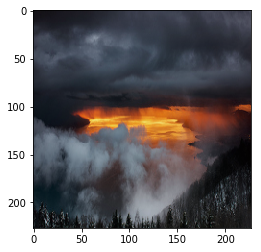

In [16]:
# Visualize input image and actual label
batch_index = 9 # [0-49]
image = style_data_batch[batch_index]
plt.imshow(deprocess_net_image(image))
print 'Actual label =', style_labels[style_label_batch[batch_index]]

In [17]:
# ImageNet predictions
disp_imagenet_preds(imagenet_net, image)

Top 5 predicted ImageNet labels =
	(1) 85.62% n09472597 volcano
	(2) 10.13% n01443537 goldfish, Carassius auratus
	(3)  1.50% n09288635 geyser
	(4)  0.33% n03388043 fountain
	(5)  0.24% n01910747 jellyfish


Look at `untrained_style_net`'s predictions, but no interesting prediction as its classifier has not been trained yet.

In fact, the classifier is zero-initialized (see `caffenet` definition -- no `weight_filler` is passed to the final `InnerProduct` layer), the softmax inputs should be all zero therefore the predicted probability is 1/N for each label (for N labels). Since N = 5 the predicted probability is 20% for each class.

In [18]:
# Untrained predictions
disp_style_preds(untrained_style_net, image)

Top 5 predicted style labels =
	(1) 20.00% Detailed
	(2) 20.00% Pastel
	(3) 20.00% Melancholy
	(4) 20.00% Noir
	(5) 20.00% HDR


Verify that the activations in layer `fc7` immediately before the classification layer are the same as (or very close to) those in the ImageNet-pretrained model, since both models are using the same pretrained weights in the `conv1` through `fc7` layers.

In [19]:
diff = untrained_style_net.blobs['fc7'].data[0] - imagenet_net.blobs['fc7'].data[0]
error = (diff ** 2).sum()
print error
assert error < 1e-8

4.10776e-09


Delete `untrained_style_net` to save memory.

In [20]:
del untrained_style_net

**3. Training the style classifier**

Now, define a function `solver` to create Caffe solvers, which are used to train the network (learn its weights).

In [21]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 100  # Test after every 1000 training iterations.
        s.test_iter.append(50) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 10000    # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 2000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = caffe_root + 'models/finetune_flickr_style/finetune_flickr_style'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        print f.name
        return f.name

Now invoke the solver to train the style net's classification layer.

Training the network using only the command line tool, this is the command:

```bash
build/tools/caffe train \
    -solver models/finetune_flickr_style/solver.prototxt \
    -weights models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel \
    -gpu 0
```

**Training network using Python**

First define `run_solvers`, a function that takes a list of solvers and steps each one in a round robin (a tournament in which each competitor plays in turn against every other) manner, recording the accuracy and loss values each iteration.  At the end, the learned weights are saved to a file.

In [23]:
def run_solvers(niter, solvers, disp_interval=100):
    """
    Run solvers for niter iterations, returning the loss and accuracy recorded each iteration.
       
    Args:
        niter (int): Number of iterations.
        solvers (list): A list of (name, solver) tuples.
        disp_interval (int): Display interval for displaying loss and accuracy.
    """
    # Create a set of dictionaries to store `loss` and `accuracy`
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers} for _ in blobs)
    
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # Run a single SGD step in Caffe
            # Store computed loss and accuracy
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)
            
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp() # Create a temporary directory
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

In [24]:
# Example: Create a set of dictionaries to store computations
n = 4
b = ('loss', 'acc')
s = [('a', 1), ('b', 2), ('c', 3), ('d', 4)]
l, a = ({name: np.zeros(n) for name, _ in s} for _ in b)
print l['a'][0], a['b'][2]
l, a 

0.0 0.0


({'a': array([ 0.,  0.,  0.,  0.]),
  'b': array([ 0.,  0.,  0.,  0.]),
  'c': array([ 0.,  0.,  0.,  0.]),
  'd': array([ 0.,  0.,  0.,  0.])},
 {'a': array([ 0.,  0.,  0.,  0.]),
  'b': array([ 0.,  0.,  0.,  0.]),
  'c': array([ 0.,  0.,  0.,  0.]),
  'd': array([ 0.,  0.,  0.,  0.])})

Create and run two solvers to train nets for the style recognition task:

1. `style_solver` will have its train net initialized to the ImageNet-pretrained weights (this is done by the call to the `copy_from` method)
2. `scratch_style_solver` will start from a *randomly* initialized net.

During training, observe that the ImageNet pretrained net is learning faster and attaining better accuracies than the scratch net.

In [25]:
# Network initialized to ImageNet pretrained weights

# # of iterations to train
niter = 1000  

# Create solver (NOTE: solver() creates a solver with temp filename)
style_solver_filename = solver(style_net(train=True))

# Get solver in Caffe
style_solver = caffe.get_solver(style_solver_filename)

# Initialize network to pretrained weights
style_solver.net.copy_from(weights)

/tmp/tmpP7tIOI
/tmp/tmpTrahee


In [26]:
help(style_solver.net.copy_from)

Help on method copy_from:

copy_from(...) method of caffe._caffe.Net instance
    copy_from( (Net)arg1, (str)arg2) -> None :
    
        C++ signature :
            void copy_from(caffe::Net<float> {lvalue},std::string)



In [27]:
# Network initialized from scratch
scratch_style_solver_filename = solver(style_net(train=True))

# Create solver 
scratch_style_solver = caffe.get_solver(scratch_style_solver_filename)

/tmp/tmpBL2yMV
/tmp/tmpCgNhWb


In [28]:
# Create a list of solver tuples: [(name, solver), ...]
solvers = [('pretrained', style_solver),
           ('scratch', scratch_style_solver)]

In [29]:
# Run solvers 
print 'Running solvers for %d iterations...' % niter

# Train
loss, acc, weights = run_solvers(niter, solvers)
print 'Done.'

train_loss, scratch_train_loss = loss['pretrained'], loss['scratch']
train_acc, scratch_train_acc = acc['pretrained'], acc['scratch']
style_weights, scratch_style_weights = weights['pretrained'], weights['scratch']

# Delete solvers to save memory.
del style_solver, scratch_style_solver, solvers

Running solvers for 1000 iterations...
  0) pretrained: loss=1.609, acc=28%; scratch: loss=1.609, acc=28%
100) pretrained: loss=1.058, acc=54%; scratch: loss=1.591, acc=28%
200) pretrained: loss=0.985, acc=64%; scratch: loss=1.583, acc=24%
300) pretrained: loss=0.852, acc=74%; scratch: loss=1.602, acc=16%
400) pretrained: loss=0.707, acc=72%; scratch: loss=1.576, acc=32%
500) pretrained: loss=1.115, acc=54%; scratch: loss=1.601, acc=16%
600) pretrained: loss=1.197, acc=62%; scratch: loss=1.573, acc=30%
700) pretrained: loss=0.514, acc=86%; scratch: loss=1.573, acc=28%
800) pretrained: loss=0.788, acc=74%; scratch: loss=1.572, acc=30%
900) pretrained: loss=0.762, acc=72%; scratch: loss=1.568, acc=28%
999) pretrained: loss=0.658, acc=76%; scratch: loss=1.582, acc=24%
Done.


Look at the training loss and accuracy produced by the two training procedures.  Notice how quickly the ImageNet pretrained model's loss value (blue) drops, and that the randomly initialized model's loss value (orange) barely (if at all) improves from training only the classifier layer.

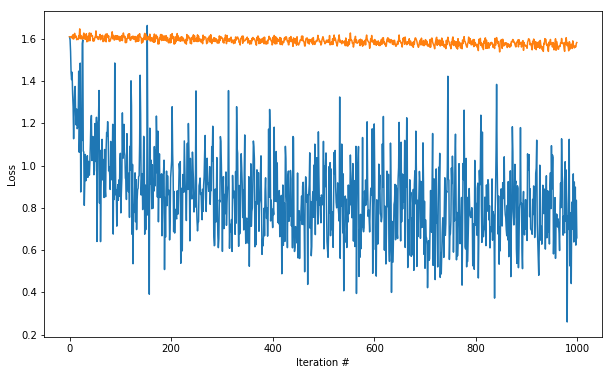

In [36]:
# Visualize training loss: Pretrained Vs Scratch
figure(figsize=(10, 6))
plot(np.vstack([train_loss, scratch_train_loss]).T)
xlabel('Iteration #')
ylabel('Loss')

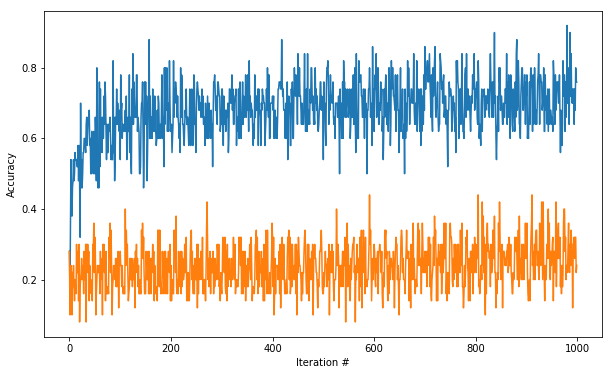

In [37]:
# Visualize accuracy: Pretrained Vs Scratch
figure(figsize=(10, 6))
plot(np.vstack([train_acc, scratch_train_acc]).T)
xlabel('Iteration #')
ylabel('Accuracy')

Look at the testing accuracy after running 1000 iterations of training. Note that there are 5 classes, giving chance accuracy of 20%. Expect both results to be better than chance accuracy (20%), and the result from training using the ImageNet pretraining initialization to be much better than the one from training from scratch.

In [38]:
def eval_style_net(weights, test_iters=10):
    test_net = caffe.Net(style_net(train=False), weights, caffe.TEST)
    accuracy = 0
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
    accuracy /= test_iters
    return test_net, accuracy

In [39]:
test_net, accuracy = eval_style_net(style_weights)
print 'Accuracy, trained from ImageNet initialization: %3.1f%%' % (100*accuracy, )
scratch_test_net, scratch_accuracy = eval_style_net(scratch_style_weights)
print 'Accuracy, trained from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

/tmp/tmpmbSCb1
Accuracy, trained from ImageNet initialization: 53.8%
/tmp/tmpNeoujz
Accuracy, trained from   random initialization: 26.2%


### 4. End-to-end finetuning for style

Train both nets again, starting from the learned weights.  Learning the weights "end-to-end" by turning on learning in *all* layers of the network, starting from the RGB `conv1` filters directly applied to the input image (pass the argument `learn_all=True` to the `style_net` function defined earlier in this notebook, which tells the function to apply a positive (non-zero) `lr_mult` value for all parameters.  

Under the default, `learn_all=False`, all parameters in the pretrained layers (`conv1` through `fc7`) are frozen (`lr_mult = 0`), and we learn only the classifier layer `fc8_flickr`.

Note that both networks start at roughly the accuracy achieved at the end of the previous training session, and improve significantly with end-to-end training.

In [41]:
# Learn all parameters
end_to_end_net = style_net(train=True, learn_all=True)

# Set base_lr to 1e-3, the same as last time when learning only the classifier.
# Play around with different values of this or other optimization parameters when fine-tuning.  
# For example, if learning diverges (e.g., the loss gets very large or goes to infinity/NaN), 
# try decreasing base_lr (e.g., to 1e-4, then 1e-5, etc., until you find a value
# for which learning does not diverge).
base_lr = 0.001

style_solver_filename = solver(end_to_end_net, base_lr=base_lr)
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(style_weights)

scratch_style_solver_filename = solver(end_to_end_net, base_lr=base_lr)
scratch_style_solver = caffe.get_solver(scratch_style_solver_filename)
scratch_style_solver.net.copy_from(scratch_style_weights)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained, end-to-end', style_solver),
           ('scratch, end-to-end', scratch_style_solver)]
_, _, finetuned_weights = run_solvers(niter, solvers)
print 'Done.'

style_weights_ft = finetuned_weights['pretrained, end-to-end']
scratch_style_weights_ft = finetuned_weights['scratch, end-to-end']

# Delete solvers to save memory.
del style_solver, scratch_style_solver, solvers

/tmp/tmpQDhreO
/tmp/tmp7mc1Dk
/tmp/tmpL5t8c_
Running solvers for 1000 iterations...
  0) pretrained, end-to-end: loss=0.691, acc=76%; scratch, end-to-end: loss=1.536, acc=36%
100) pretrained, end-to-end: loss=0.492, acc=84%; scratch, end-to-end: loss=1.421, acc=30%
200) pretrained, end-to-end: loss=0.459, acc=80%; scratch, end-to-end: loss=1.345, acc=38%
300) pretrained, end-to-end: loss=0.296, acc=90%; scratch, end-to-end: loss=1.329, acc=38%
400) pretrained, end-to-end: loss=0.256, acc=90%; scratch, end-to-end: loss=1.135, acc=54%
500) pretrained, end-to-end: loss=0.272, acc=96%; scratch, end-to-end: loss=1.283, acc=50%
600) pretrained, end-to-end: loss=0.377, acc=82%; scratch, end-to-end: loss=1.316, acc=42%
700) pretrained, end-to-end: loss=0.087, acc=96%; scratch, end-to-end: loss=1.073, acc=64%
800) pretrained, end-to-end: loss=0.149, acc=96%; scratch, end-to-end: loss=1.102, acc=54%
900) pretrained, end-to-end: loss=0.216, acc=92%; scratch, end-to-end: loss=1.206, acc=36%
999) p

Now test the end-to-end finetuned models.  Since all layers have been optimized for the style recognition task at hand. Expect both nets to get better results than the ones above, which were achieved by nets with only their classifier layers trained for the style task (on top of either ImageNet pretrained or randomly initialized weights).

In [42]:
test_net, accuracy = eval_style_net(style_weights_ft)
print 'Accuracy, finetuned from ImageNet initialization: %3.1f%%' % (100*accuracy, )
scratch_test_net, scratch_accuracy = eval_style_net(scratch_style_weights_ft)
print 'Accuracy, finetuned from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

/tmp/tmpy0dUKN
Accuracy, finetuned from ImageNet initialization: 55.2%
/tmp/tmpV3e0M3
Accuracy, finetuned from   random initialization: 49.6%


Look back at the image we started with and check our end-to-end trained model's predictions.

Top 5 predicted style labels =
	(1) 100.00% HDR
	(2)  0.00% Melancholy
	(3)  0.00% Detailed
	(4)  0.00% Noir
	(5)  0.00% Pastel


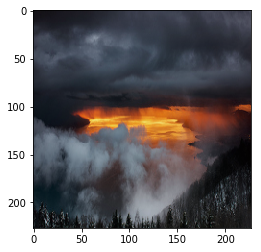

In [43]:
plt.imshow(deprocess_net_image(image))
disp_style_preds(test_net, image)

This looks a lot better than before!  But note that this image was from the training set, so the net got to see its label at training time.

Finally, pick an image from the test set and look at end-to-end finetuned style model's predictions for it.

Actual label = Pastel


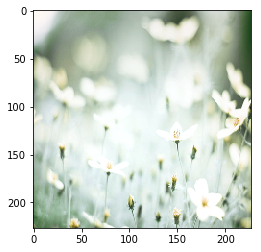

In [58]:
batch_index = 15
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'Actual label =', style_labels[int(test_net.blobs['label'].data[batch_index])]

In [59]:
disp_style_preds(test_net, image)

Top 5 predicted style labels =
	(1) 100.00% Pastel
	(2)  0.00% Melancholy
	(3)  0.00% HDR
	(4)  0.00% Detailed
	(5)  0.00% Noir


Look at the predictions of the network trained from scratch.  The scratch network also predicts the correct label for the image (*Pastel*), but is much less confident in its prediction than the pretrained net.

In [61]:
disp_style_preds(scratch_test_net, image)

Top 5 predicted style labels =
	(1) 36.00% Pastel
	(2) 32.84% Melancholy
	(3) 16.93% Detailed
	(4) 11.00% HDR
	(5)  3.23% Noir


Look at the ImageNet model's predictions for the above image:

In [62]:
disp_imagenet_preds(imagenet_net, image)

Top 5 predicted ImageNet labels =
	(1) 28.13% n04275548 spider web, spider's web
	(2)  7.97% n07714990 broccoli
	(3)  6.01% n02219486 ant, emmet, pismire
	(4)  5.24% n02206856 bee
	(5)  4.23% n04209239 shower curtain
